

---

Por: Ángela Daniela Córdoba Álvarez


---



# Introduction

***Aim and outline***

This notebook utilizes a dataset containing the results of the chemical analysis of Italian wines to **explore a range of clustering algorithms**. The dataset is small and fairly simple.

The following algorithms are applied and then compared:
- **K-means**, a centroid-based algo
- **Mean shift**, a centroid-based algo
- **Gaussian mixture**, a distribution-based algo
- **Affinity propagation**
- **DBSCAN**, a density-based algo
- **OPTICS**, a density-based algo

See https://developers.google.com/machine-learning/clustering/clustering-algorithms for a brief description of how to categorize clustering algos.

In order to keep this notebook reasonably compact, **only the most important hyperparameter will be tuned for each algo**.

The very brief EDA section of this notebook is identical to the one of an earlier notebook of mine, https://www.kaggle.com/code/dexmasa/clustering-wine-k-means-pca-or-umap/notebook, and just reproduced here for the sake of context and convenience.

When it comes to getting an idea of what a particular clustering algorithm does and how it does it, I found it very useful to look at the visualisation of its "steps". Here the link to one such visualisations I found quite useful: https://www.digitalvidya.com/blog/the-top-5-clustering-algorithms-data-scientists-should-know/



***Link to dataset***

https://www.kaggle.com/datasets/harrywang/wine-dataset-for-clustering


***Data dictionary (from above source)***

Features (all numercial):
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline


In [1]:
!pip install umap-learn
!pip install --upgrade umap-learn

**Imports and global settings**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

# EDA

**Reading in the dataset**

In [3]:
df = pd.read_csv("anemia.csv")

df.head()


WBC  LYMp  NEUTp  LYMn  NEUTn   RBC  HGB    HCT   MCV   MCH  MCHC    PLT  \
0  10.0  43.2   50.1   4.3    5.0  2.77  7.3   24.2  87.7  26.3  30.1  189.0   
1  10.0  42.4   52.3   4.2    5.3  2.84  7.3   25.0  88.2  25.7  20.2  180.0   
2   7.2  30.7   60.7   2.2    4.4  3.97  9.0   30.5  77.0  22.6  29.5  148.0   
3   6.0  30.2   63.5   1.8    3.8  4.22  3.8   32.8  77.9  23.2  29.8  143.0   
4   4.2  39.1   53.7   1.6    2.3  3.93  0.4  316.0  80.6  23.9  29.7  236.0   

    PDW   PCT                      Diagnosis  
0  12.5  0.17  Normocytic hypochromic anemia  
1  12.5  0.16  Normocytic hypochromic anemia  
2  14.3  0.14         Iron deficiency anemia  
3  11.3  0.12         Iron deficiency anemia  
4  12.8  0.22  Normocytic hypochromic anemia

**Any duplicate rows?**

In [4]:
n_dup = len(df) - len(df.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 49


**Any missing values?**

In [5]:
df.isnull().sum()

WBC          0
LYMp         0
NEUTp        0
LYMn         0
NEUTn        0
RBC          0
HGB          0
HCT          0
MCV          0
MCH          0
MCHC         0
PLT          0
PDW          0
PCT          0
Diagnosis    0
dtype: int64

**Checking data types**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1281 entries, 0 to 1280
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WBC        1281 non-null   float64
 1   LYMp       1281 non-null   float64
 2   NEUTp      1281 non-null   float64
 3   LYMn       1281 non-null   float64
 4   NEUTn      1281 non-null   float64
 5   RBC        1281 non-null   float64
 6   HGB        1281 non-null   float64
 7   HCT        1281 non-null   float64
 8   MCV        1281 non-null   float64
 9   MCH        1281 non-null   float64
 10  MCHC       1281 non-null   float64
 11  PLT        1281 non-null   float64
 12  PDW        1281 non-null   float64
 13  PCT        1281 non-null   float64
 14  Diagnosis  1281 non-null   object 
dtypes: float64(14), object(1)
memory usage: 150.2+ KB


**Cleaning up column names (mainly for handling purposes)**

In [7]:
cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower())

df.columns = cols_cleaned

df.head()

wbc  lymp  neutp  lymn  neutn   rbc  hgb    hct   mcv   mch  mchc    plt  \
0  10.0  43.2   50.1   4.3    5.0  2.77  7.3   24.2  87.7  26.3  30.1  189.0   
1  10.0  42.4   52.3   4.2    5.3  2.84  7.3   25.0  88.2  25.7  20.2  180.0   
2   7.2  30.7   60.7   2.2    4.4  3.97  9.0   30.5  77.0  22.6  29.5  148.0   
3   6.0  30.2   63.5   1.8    3.8  4.22  3.8   32.8  77.9  23.2  29.8  143.0   
4   4.2  39.1   53.7   1.6    2.3  3.93  0.4  316.0  80.6  23.9  29.7  236.0   

    pdw   pct                      diagnosis  
0  12.5  0.17  Normocytic hypochromic anemia  
1  12.5  0.16  Normocytic hypochromic anemia  
2  14.3  0.14         Iron deficiency anemia  
3  11.3  0.12         Iron deficiency anemia  
4  12.8  0.22  Normocytic hypochromic anemia

In [8]:
# Eliminamos todas aquellas filas que contengan 'NaN'
df.dropna()

wbc    lymp   neutp     lymn    neutn   rbc   hgb       hct   mcv  \
0     10.00  43.200  50.100  4.30000  5.00000  2.77   7.3   24.2000  87.7   
1     10.00  42.400  52.300  4.20000  5.30000  2.84   7.3   25.0000  88.2   
2      7.20  30.700  60.700  2.20000  4.40000  3.97   9.0   30.5000  77.0   
3      6.00  30.200  63.500  1.80000  3.80000  4.22   3.8   32.8000  77.9   
4      4.20  39.100  53.700  1.60000  2.30000  3.93   0.4  316.0000  80.6   
...     ...     ...     ...      ...      ...   ...   ...       ...   ...   
1276   4.40  25.845  77.511  1.88076  5.14094  4.86  13.5   46.1526  80.7   
1277   5.60  25.845  77.511  1.88076  5.14094  4.85  15.0   46.1526  91.7   
1278   9.20  25.845  77.511  1.88076  5.14094  4.47  13.1   46.1526  88.7   
1279   6.48  25.845  77.511  1.88076  5.14094  4.75  13.2   46.1526  86.7   
1280   8.80  25.845  77.511  1.88076  5.14094  4.95  15.2   46.1526  89.7   

       mch  mchc    plt        pdw      pct                      diagnosis  
0     26.3  30.1  189.0  12.500000  0.17000  Normocytic hypochromic anemia  
1     25.7  20.2  180.0  12.500000  0.16000  Normocytic hypochromic anemia  
2     22.6  29.5  148.0  14.300000  0.14000         Iron deficiency anemia  
3     23.2  29.8  143.0  11.300000  0.12000         Iron deficiency anemia  
4     23.9  29.7  236.0  12.800000  0.22000  Normocytic hypochromic anemia  
...    ...   ...    ...        ...      ...                            ...  
1276  27.7  34.4  180.0  14.312512  0.26028                        Healthy  
1277  31.0  33.8  215.0  14.312512  0.26028                        Healthy  
1278  29.3  33.0  329.0  14.312512  0.26028                        Healthy  
1279  27.9  32.1  174.0  14.312512  0.26028                        Healthy  
1280  30.6  34.2  279.0  14.312512  0.26028                        Healthy  

[1281 rows x 15 columns]

**Quick overview over the individual distributions**

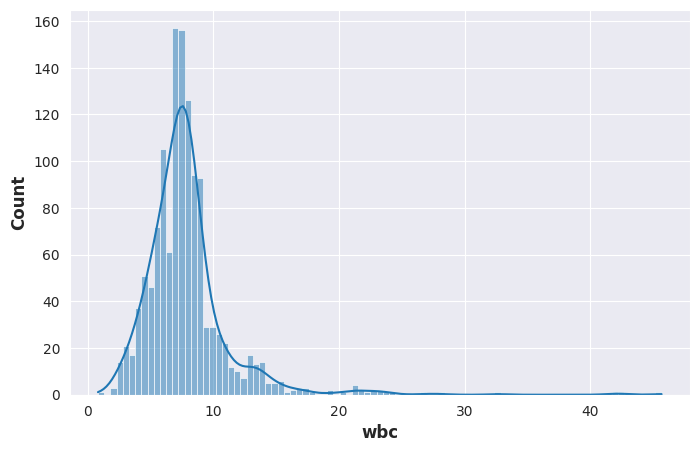

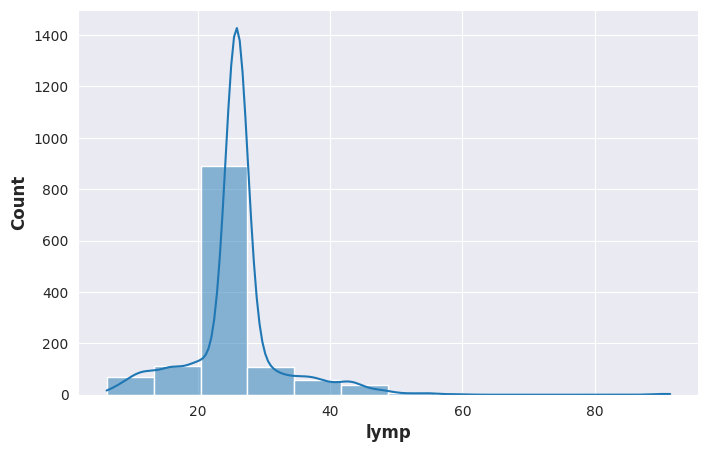

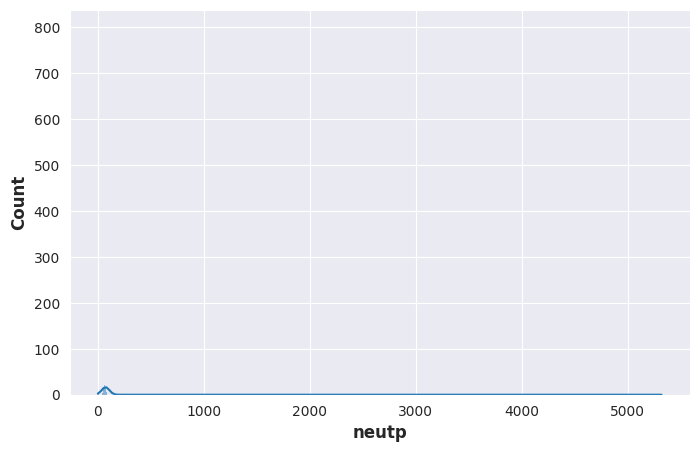

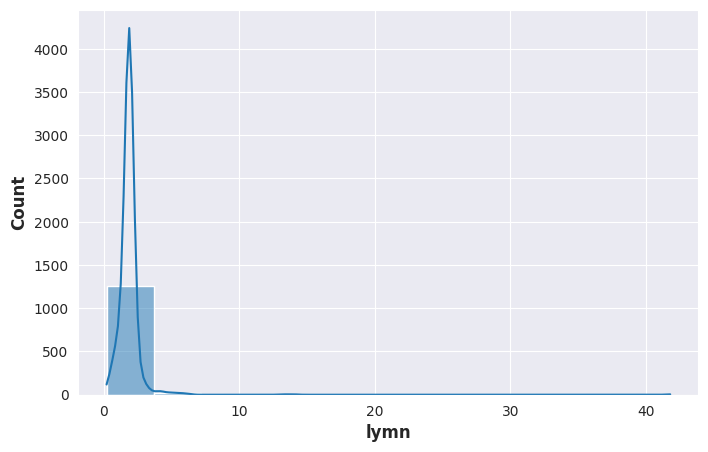

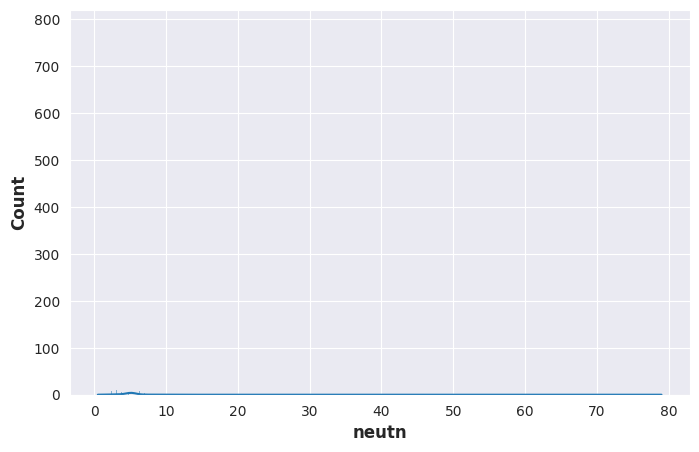

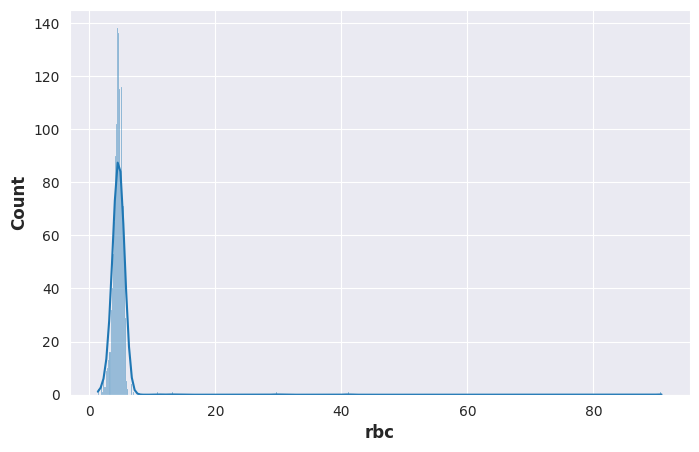

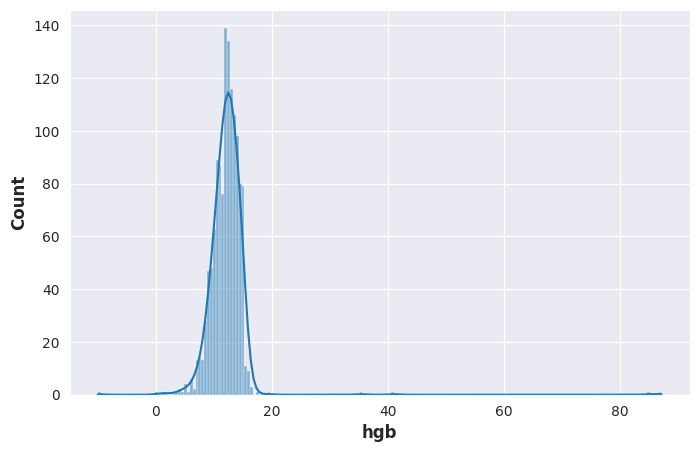

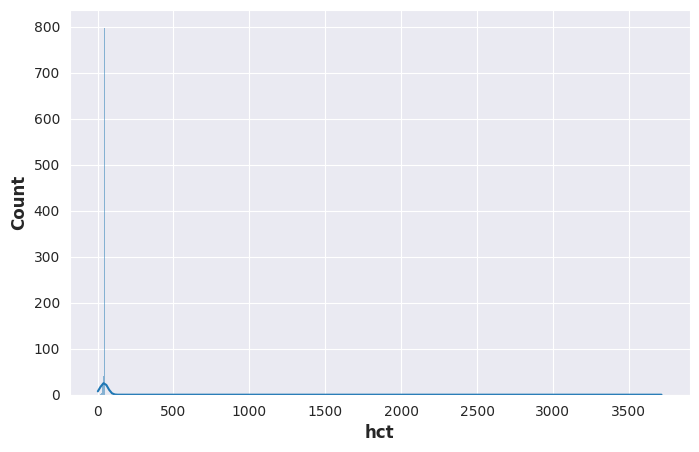

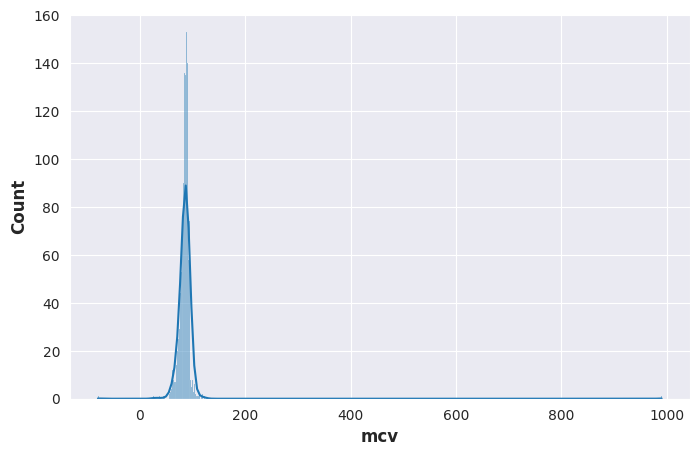

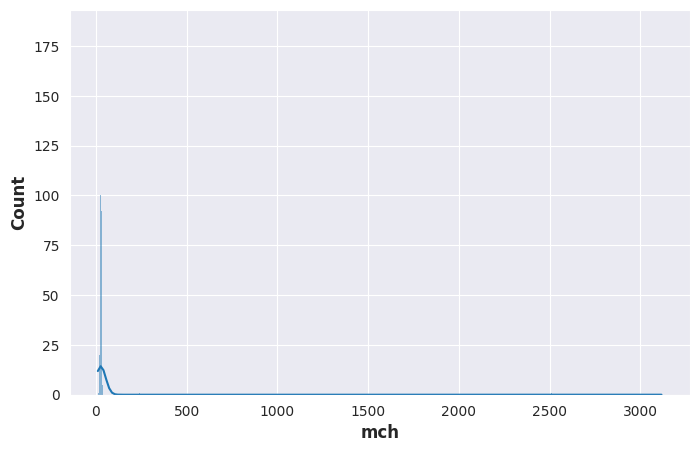

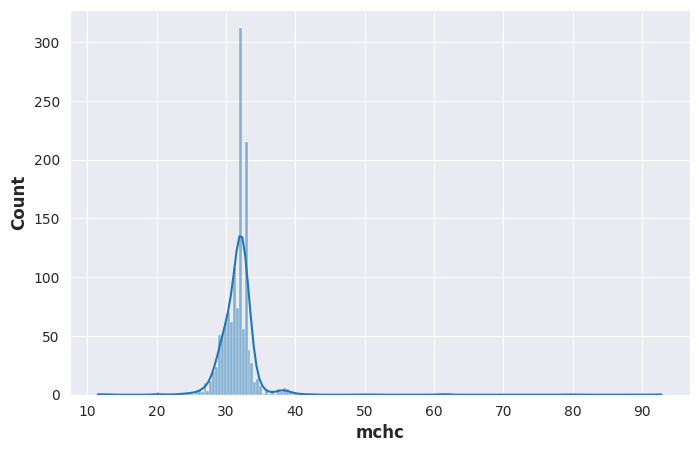

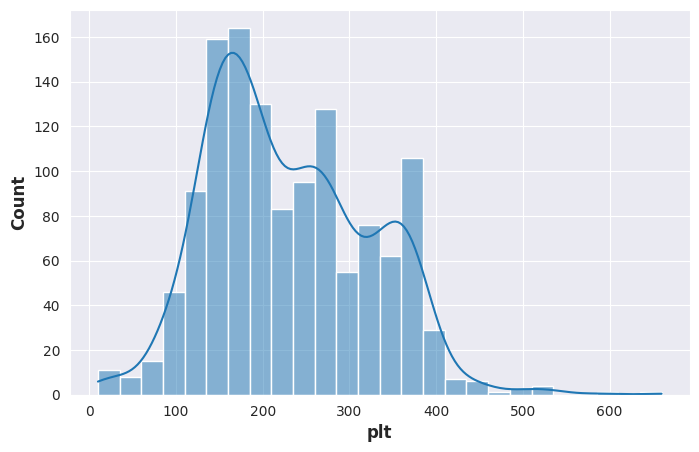

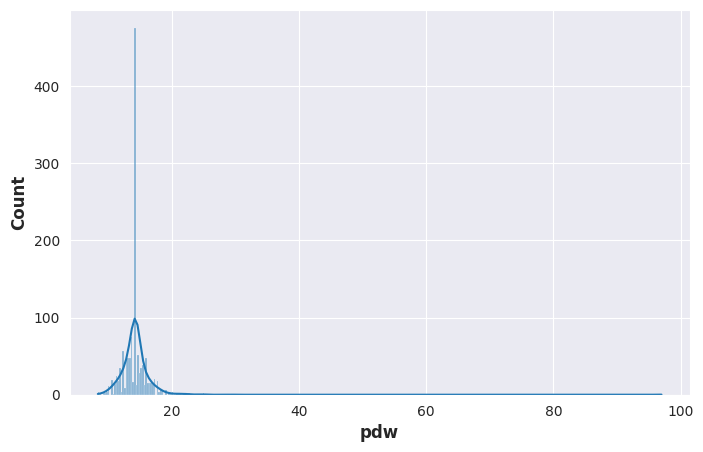

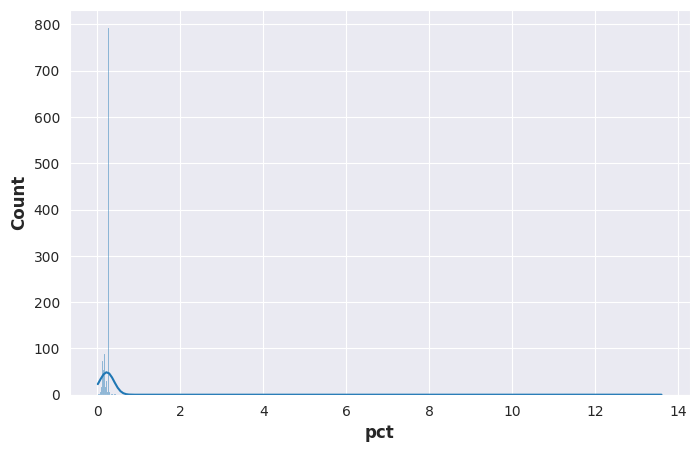

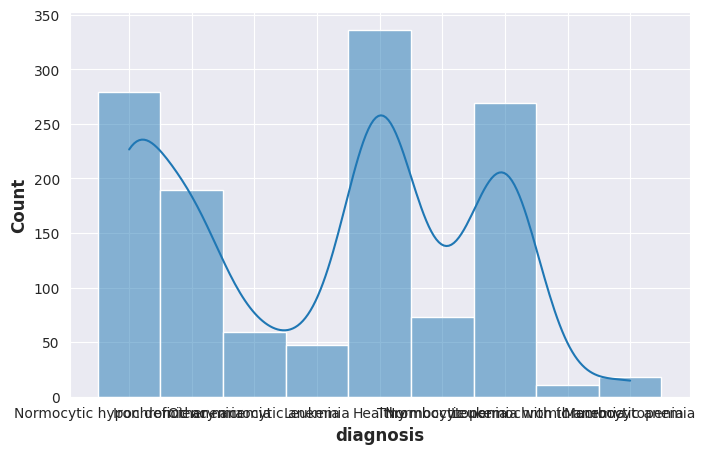

In [9]:
for col in df.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()

==> Distributions require scaling and standardization.

# Clustering

In [10]:
algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]

# saving training times for each algo
training_times = []

## Scaling and Standardizing

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder

# Scaling y Standardizing
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])
df = df.drop(columns=['diagnosis'])
df

wbc    lymp   neutp     lymn    neutn   rbc   hgb       hct   mcv  \
0     10.00  43.200  50.100  4.30000  5.00000  2.77   7.3   24.2000  87.7   
1     10.00  42.400  52.300  4.20000  5.30000  2.84   7.3   25.0000  88.2   
2      7.20  30.700  60.700  2.20000  4.40000  3.97   9.0   30.5000  77.0   
3      6.00  30.200  63.500  1.80000  3.80000  4.22   3.8   32.8000  77.9   
4      4.20  39.100  53.700  1.60000  2.30000  3.93   0.4  316.0000  80.6   
...     ...     ...     ...      ...      ...   ...   ...       ...   ...   
1276   4.40  25.845  77.511  1.88076  5.14094  4.86  13.5   46.1526  80.7   
1277   5.60  25.845  77.511  1.88076  5.14094  4.85  15.0   46.1526  91.7   
1278   9.20  25.845  77.511  1.88076  5.14094  4.47  13.1   46.1526  88.7   
1279   6.48  25.845  77.511  1.88076  5.14094  4.75  13.2   46.1526  86.7   
1280   8.80  25.845  77.511  1.88076  5.14094  4.95  15.2   46.1526  89.7   

       mch  mchc    plt        pdw      pct  
0     26.3  30.1  189.0  12.500000  0.17000  
1     25.7  20.2  180.0  12.500000  0.16000  
2     22.6  29.5  148.0  14.300000  0.14000  
3     23.2  29.8  143.0  11.300000  0.12000  
4     23.9  29.7  236.0  12.800000  0.22000  
...    ...   ...    ...        ...      ...  
1276  27.7  34.4  180.0  14.312512  0.26028  
1277  31.0  33.8  215.0  14.312512  0.26028  
1278  29.3  33.0  329.0  14.312512  0.26028  
1279  27.9  32.1  174.0  14.312512  0.26028  
1280  30.6  34.2  279.0  14.312512  0.26028  

[1281 rows x 14 columns]

In [12]:
X = StandardScaler().fit_transform(df)

In [13]:
# Ver si hay valores negativos
print(np.any(X < 0))

True


In [14]:
transformer = PowerTransformer(standardize=False)
X_transformed = transformer.fit_transform(X)

# Ajustar los valores para que sean positivos
X_transformed += np.abs(np.min(X_transformed))

In [15]:
# Seleccionar las columnas numéricas que quieres transformar
numerical_columns = df.select_dtypes(include=[np.number]).columns
X = df[numerical_columns]

# Manejar valores nulos si existen (rellenamos con la media de cada columna)
X = X.fillna(X.mean())

# Aplicar PowerTransformer
pt = PowerTransformer(standardize=False)
X_transformed = pt.fit_transform(X)

# Mostrar los datos transformados
print(X_transformed)

[[ 1.91863151 12.58293256  4.21154977 ... 42.30643237  1.02001933
   0.12549859]
 [ 1.91863151 12.44047071  4.25982611 ... 40.97727182  1.02001933
   0.12004311]
 [ 1.72854907 10.19919487  4.42798041 ... 36.04064145  1.03196806
   0.10855422]
 ...
 [ 1.87079983  9.15921161  4.70668473 ... 60.69044609  1.03204184
   0.16735381]
 [ 1.66683035  9.15921161  4.70668473 ... 40.07769338  1.03204184
   0.16735381]
 [ 1.84517314  9.15921161  4.70668473 ... 54.53240389  1.03204184
   0.16735381]]


In [16]:
from sklearn.preprocessing import PowerTransformer

X = PowerTransformer(standardize=False).fit_transform(X)

In [17]:
X = pd.DataFrame(X, columns=df.columns)

# sanity check
X.head()

wbc       lymp     neutp      lymn     neutn       rbc       hgb  \
0  1.918632  12.582933  4.211550  1.172911  1.606105  0.900463  5.082670   
1  1.918632  12.440471  4.259826  1.163881  1.645028  0.908414  5.082670   
2  1.728549  10.199195  4.427980  0.905518  1.521242  1.010740  6.028039   
3  1.621603  10.095621  4.479142  0.823986  1.425047  1.028401  2.948133   
4  1.411616  11.839715  4.289555  0.776578  1.109485  1.007779  0.381711   

        hct        mcv       mch      mchc        plt       pdw       pct  
0  2.407035  51.902481  1.056013  2.616726  42.306432  1.020019  0.125499  
1  2.423832  52.156416  1.054862  2.393555  40.977272  1.020019  0.120043  
2  2.524788  46.414017  1.048038  2.605721  36.040641  1.031968  0.108554  
3  2.560943  46.879850  1.049488  2.611255  35.235573  1.010237  0.096237  
4  3.488622  48.272582  1.051096  2.609417  48.905668  1.022214  0.150192

## Dimensionality reduction via UMAP

Prior to clustering, the number of features is reduced from 13 to 2. The main reason behind this is to be able to **directly "see" if the identified clusters make sense**. In addition to this, (i) similarity metrics tend to work better in lower dimensions (distance measures degenerate for large numbers of input features), and (ii) this dimensionality reduction also mitigates the relatively poor "obervations to features ratio" for this dataset.

In [18]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

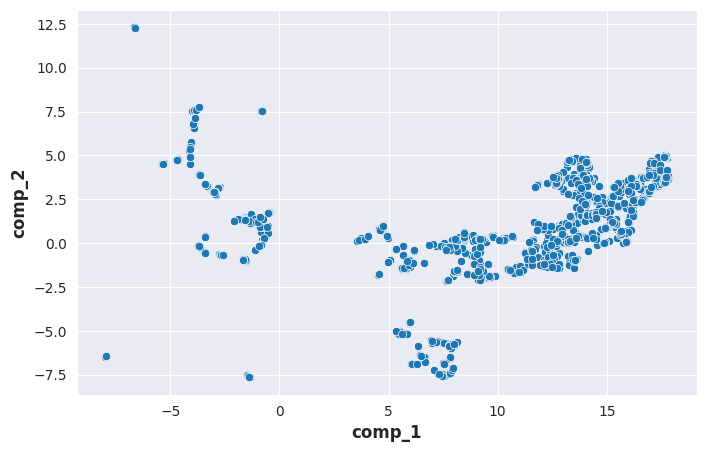

In [19]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

## Definition of plotting and convergence check function

In [20]:
# function to visualize identified clusters

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):
    """Visualisation of identified clusters. Only a single hyperparameter is considered.

    Arguments
    =========
    df: pandas.DataFrame
        Dataframe of input features.
    labels_all: list | numpy.array
        Identified cluster IDs.
    hyperparam_name: str | None
        Name of hyperparameter.
    hyperparam_val: float | int | None
        Value of hyperparameter.
    noise_exist: bool
        True if algo models noise, False otherwise.
        Assumes encoding of noise as cluster ID = -1.

    Returns
    =======
    None
    Prints a figure.

    """

    # Checking of input parameters omitted for this notebook

    labels = sorted(pd.Series(labels_all).unique())

    if noise_exist:

        outlier_perc = int(round(( (len(df) - sum(np.where(labels_all == -1, False, True))) / len(df) ) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"
            else:
                marker_style = "o"
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Noise': {outlier_perc}%")
        else:
            plt.title(f"Defaults for all hyperparameters; 'Noise': {outlier_perc}%")
        plt.legend(title="cluster ID")
        plt.show()

    else:

        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Defaults for all hyperparameters")
        plt.legend(title="cluster ID")
        plt.show()


def convergence_check(model):
    """Checking if fitted model converged within the max. number of iterations."""
    if model.n_iter_ < model.max_iter:
        print(f"Algorithm converged successfully!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"WARNING: Algorithm did not converge within {model.max_iter} iterations!\n")

## Algo 1: K-means

K-means is the most well-known and "basic" clustering algorithm.
Its most important hyperparamter is ***n_clusters***, which is the number of clusters for the algo to look for.

In [21]:
# hyperparameter to tune

kmeans_hparam = "n_clusters"

### Identifying the "optimal" number of clusters

In the context of clustering via K-means, the sum of squared distances of points to their respective centroid is known as "**inertia**". Finding an appropriate number of clusters here means finding the point of diminishing returns when increasing the number of centroids. This is done visually via identifying a potential kink in the inertia vs. number of clusters plot.

In [22]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

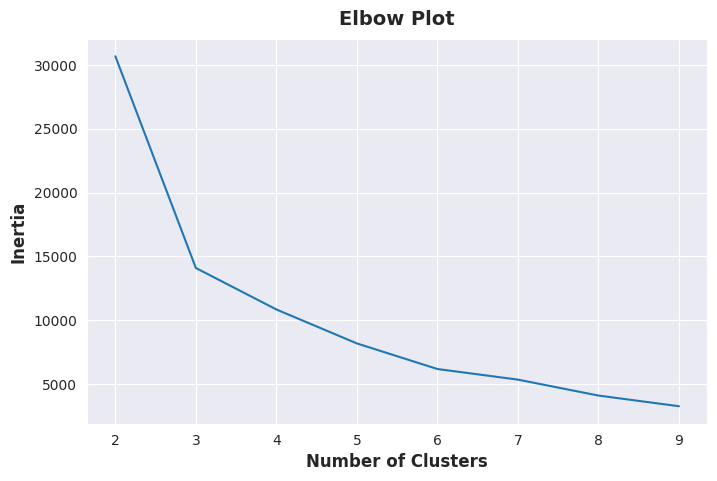

In [23]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### Run with optimised *n_clusters*

In [24]:
%%time

start_time = time.time()

kmeans = KMeans(n_clusters=3, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 5, max_iter: 300

CPU times: user 38.8 ms, sys: 993 µs, total: 39.8 ms
Wall time: 23.9 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


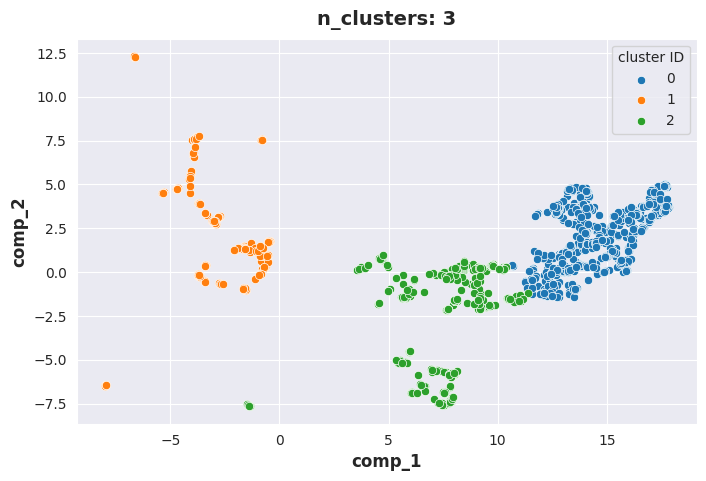

In [25]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=3, noise_exist=False)

## Algo 2: Mean shift

Similar to K-means, Mean shift is a centroid-based algorithm. In contrast to K-means, however, there is **no requirement to specify the number of clusters upfront**. Its main hyperparameter is ***bandwidth***, which represents the extent of the "local search regions". If this parameter is not specified, however, sklearn does provide an estimation for it. Additionally, Mean shift also comes with the option to not necessarily associate all data points with a cluster via setting *cluster_all* to *False*. This aspect of the alogrithm is also explored in the following.

In [26]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

### Vanilla run (defaults for all hyperparameters)

In [27]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Algorithm converged successfully!
n_iter: 15, max_iter: 300

CPU times: user 573 ms, sys: 167 ms, total: 740 ms
Wall time: 5.54 s


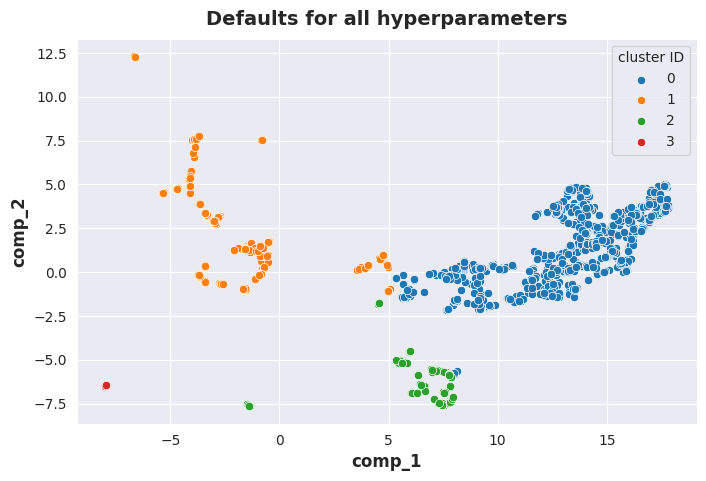

In [28]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

==> The estimation for *bandwidth* seems to work well here. There is thus no need for any further tuning of this hyperparameter.

### Allowing for 'noise'

This is enabled by setting *cluster_all=False*.

In [29]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

Algorithm converged successfully!
n_iter: 15, max_iter: 300

CPU times: user 457 ms, sys: 23.7 ms, total: 481 ms
Wall time: 6.43 s


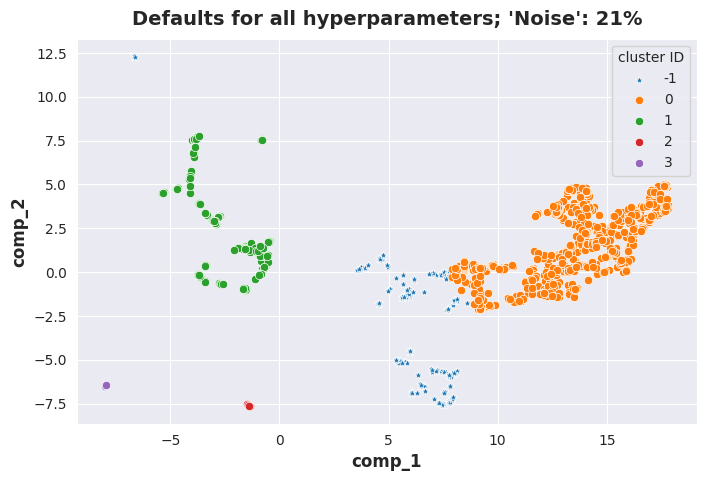

In [30]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Data points that the algorithm identifies as "not being part of any cluster" (i.e. 'noise' or 'orphans') are marked as blue stars (cluster ID: -1).

==> Results look sensible but not substantially different to the solution for the default *cluster_all=True* for this dataset.

## Algo 3: Gaussian Mixture

The Gaussian mixture model is, as the name suggests, a distribution-based algorithm. Its main hyperparamter is ***n_components***, which corresponds to the number of clusters to form. As a shortcut here, the number of clusters as identified in the K-means section is adopted.

In [31]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [32]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)

labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 10, max_iter: 100

CPU times: user 80.3 ms, sys: 16.1 ms, total: 96.4 ms
Wall time: 102 ms


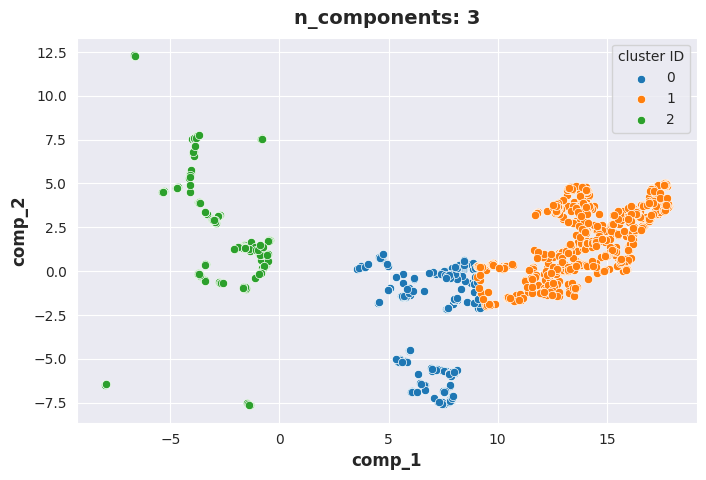

In [33]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=3, noise_exist=False)

==> The results look quite reasonable. This is, again, not completely unexpected as the structure of the data does form more of less **elliptic "blobs"** in 2D, which is what the Gaussian mixture model is quite good at capturing.

## Algo 4: Affinity propagation

Affinity propagation does not require specifying the number of clusters upfront. Its main hyperparameter is ***damping***, which is a value in the range of 0.5 (incl.) to 1.0 (excl.).

In [34]:
# hyperparamter to tune

affprop_hparam = "damping"

### Vanilla run (defaults for all hyperparameters)

In [35]:
%%time

affprop = AffinityPropagation(random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)


CPU times: user 6.18 s, sys: 117 ms, total: 6.29 s
Wall time: 6.37 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


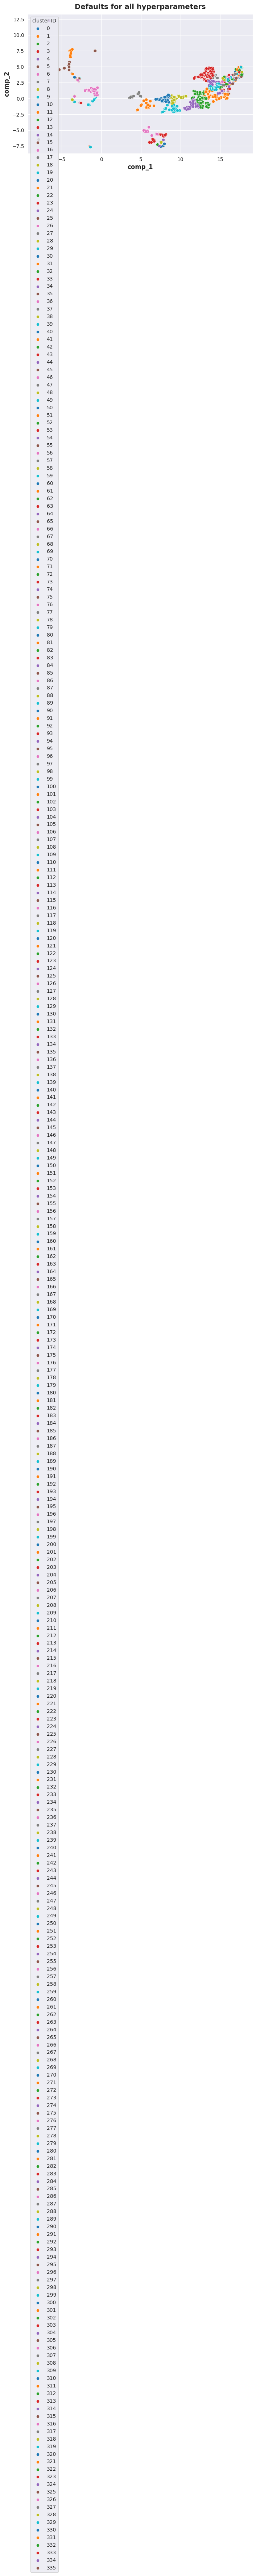

In [36]:
visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

==> The vanilla algo finds a lot more clusters than the 3 that were expected. There is a possibility, however, that those "additional" clusters actually represent something that could be of interest here, but this is beyond the scope of this exercise.

### Tuning runs for "damping"

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


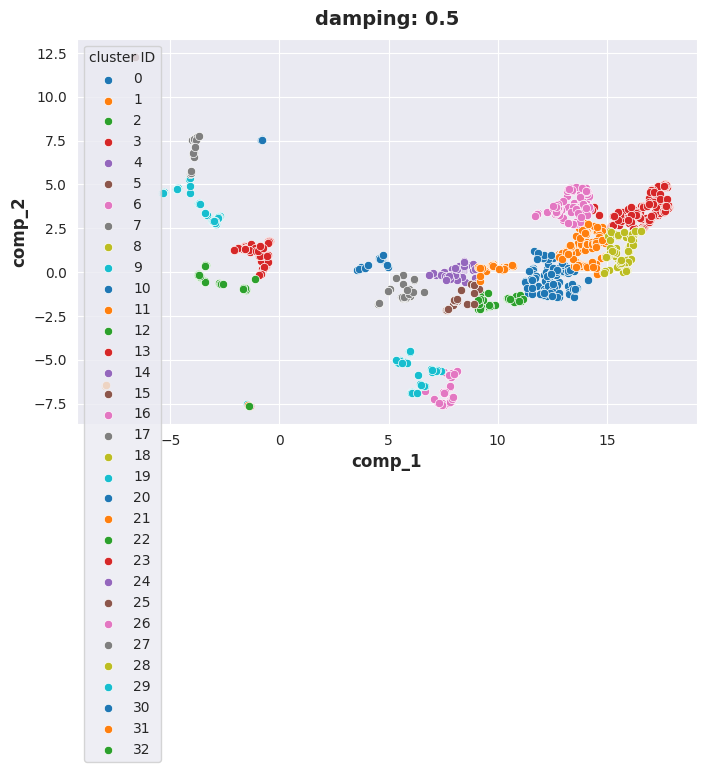

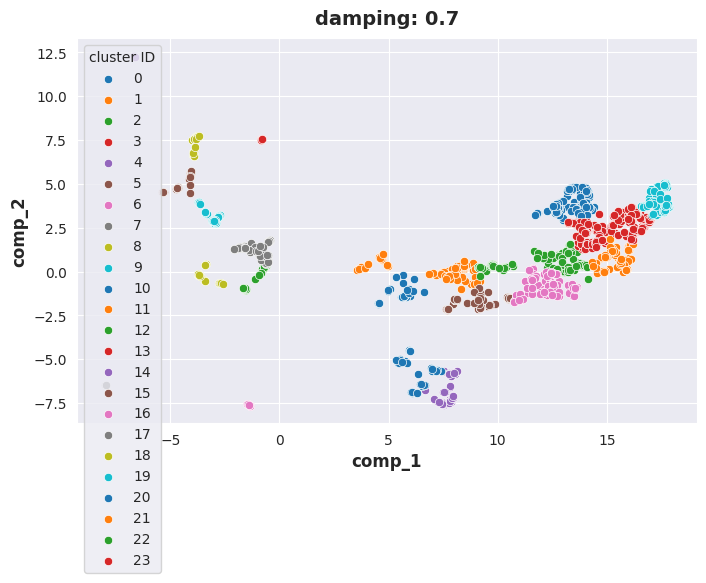

Algorithm converged successfully!
n_iter: 49, max_iter: 500



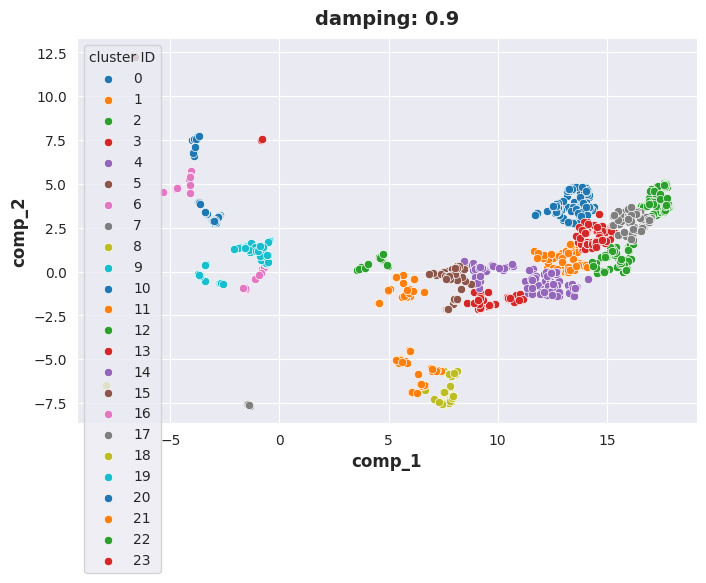

Algorithm converged successfully!
n_iter: 87, max_iter: 500



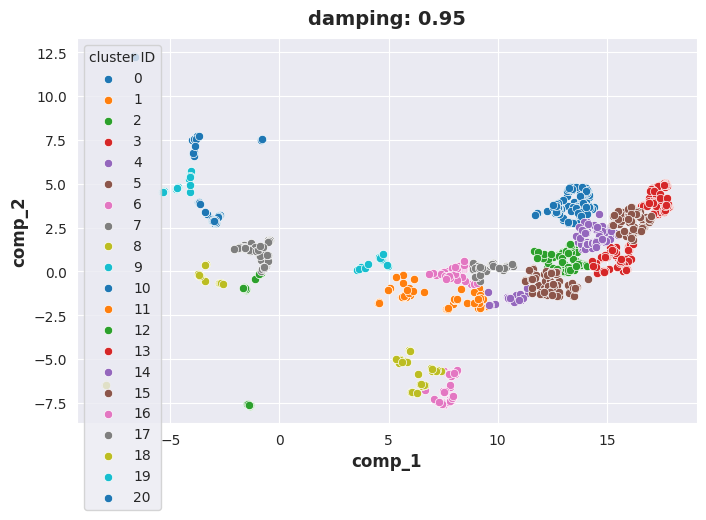

Algorithm converged successfully!
n_iter: 89, max_iter: 500



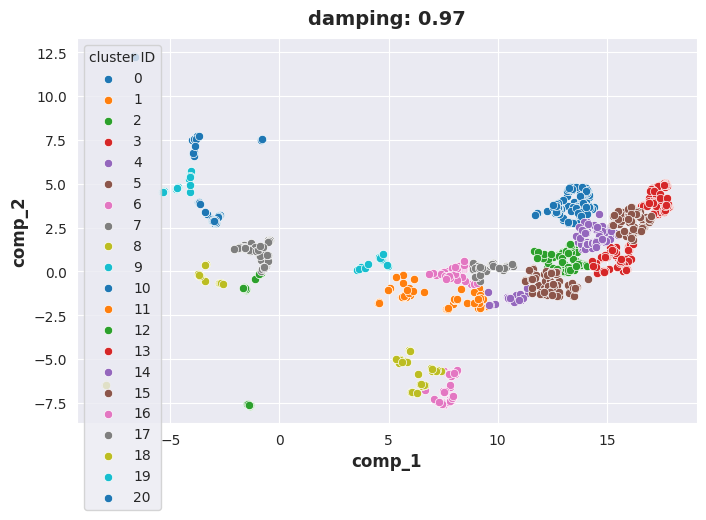

Algorithm converged successfully!
n_iter: 140, max_iter: 500



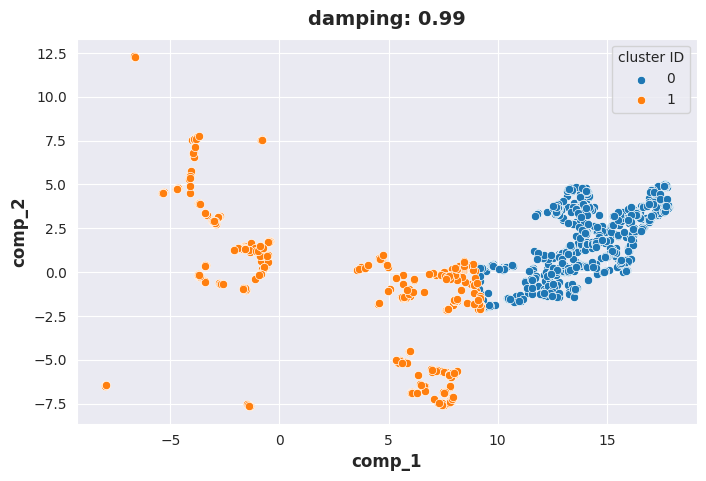

Algorithm converged successfully!
n_iter: 255, max_iter: 500

CPU times: user 46.3 s, sys: 1.27 s, total: 47.6 s
Wall time: 48.5 s


In [37]:
%%time

damps = [0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

for d in damps:
    affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
    convergence_check(affprop)

==> Tuning "damping" does not seem to be very "effective" for this dataset!

### Tuning runs for "preference"

In order to still get to the "expected solution" of finding 3 clusters, another hyperparamter, ***preference*** is investigated. As stated in the beginning though, the self-imposed contraint here is to only tune a single hyperparameter, leaving all others at their default values, i.e. not looking for any interactions between them.

In [38]:
# hyperparamter to tune

affprop_hparam = "preference"

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


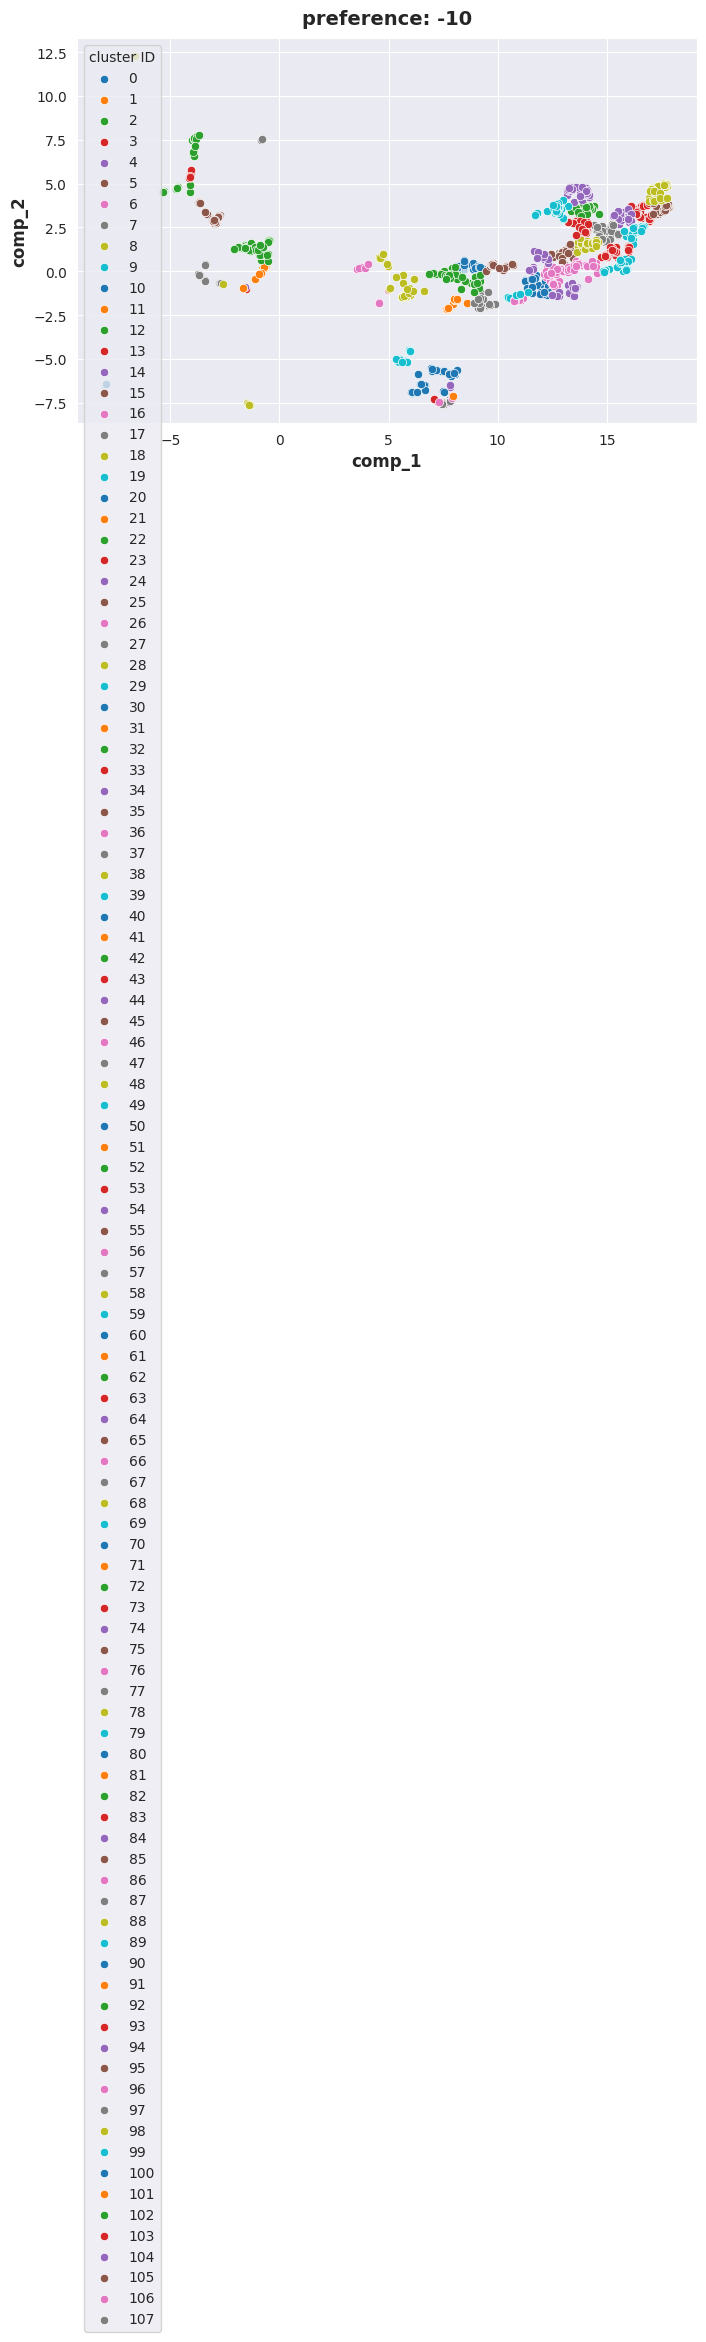

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


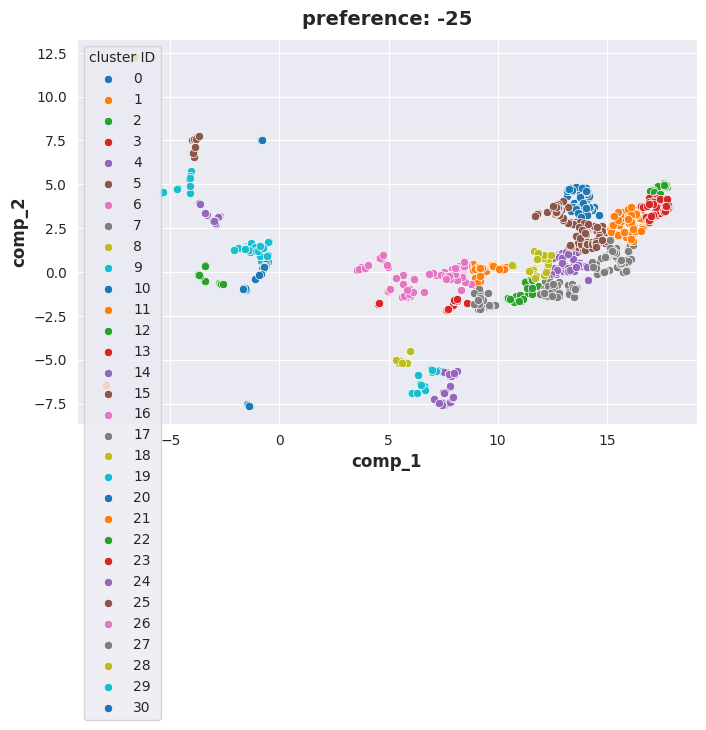

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


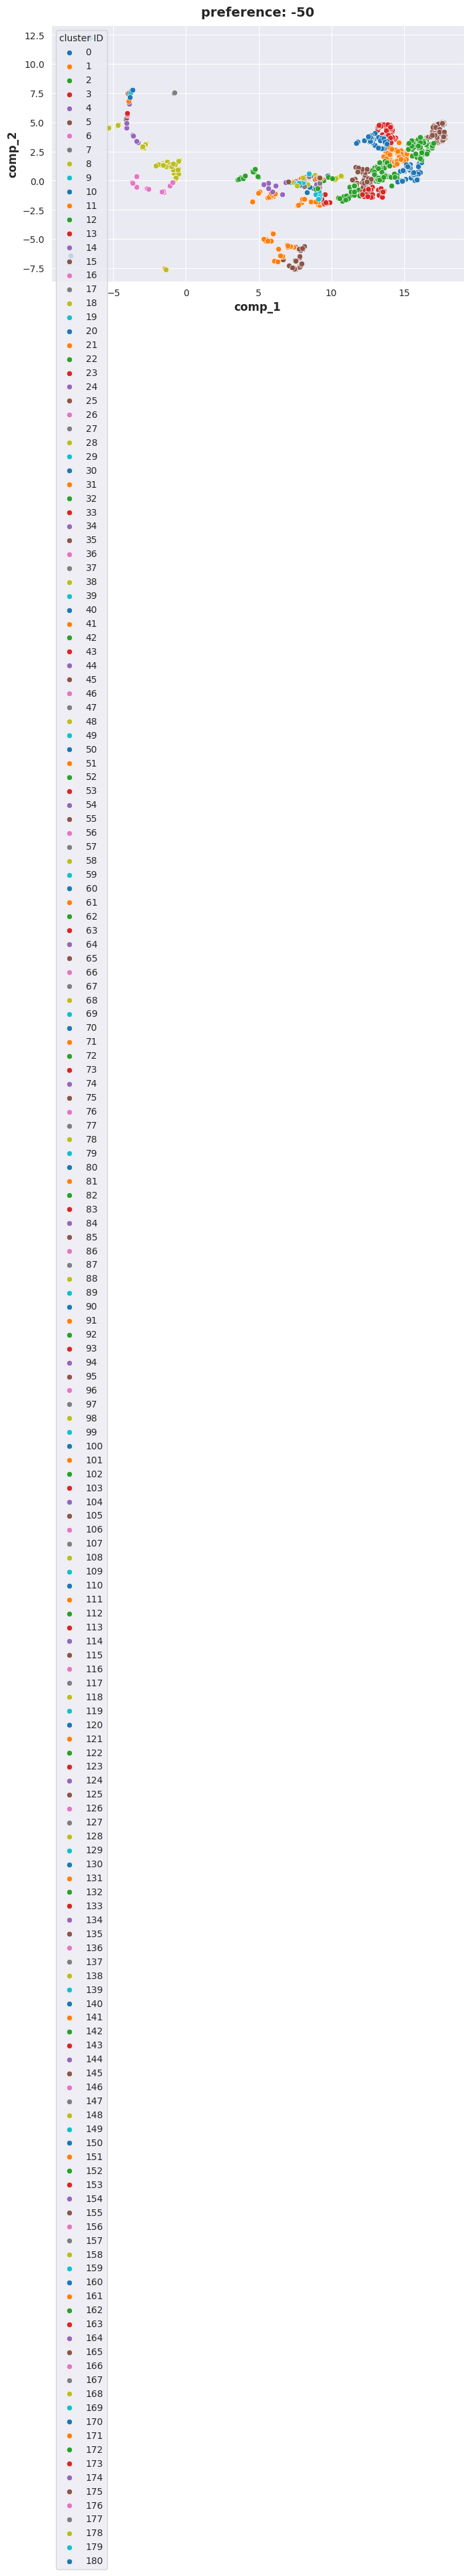

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


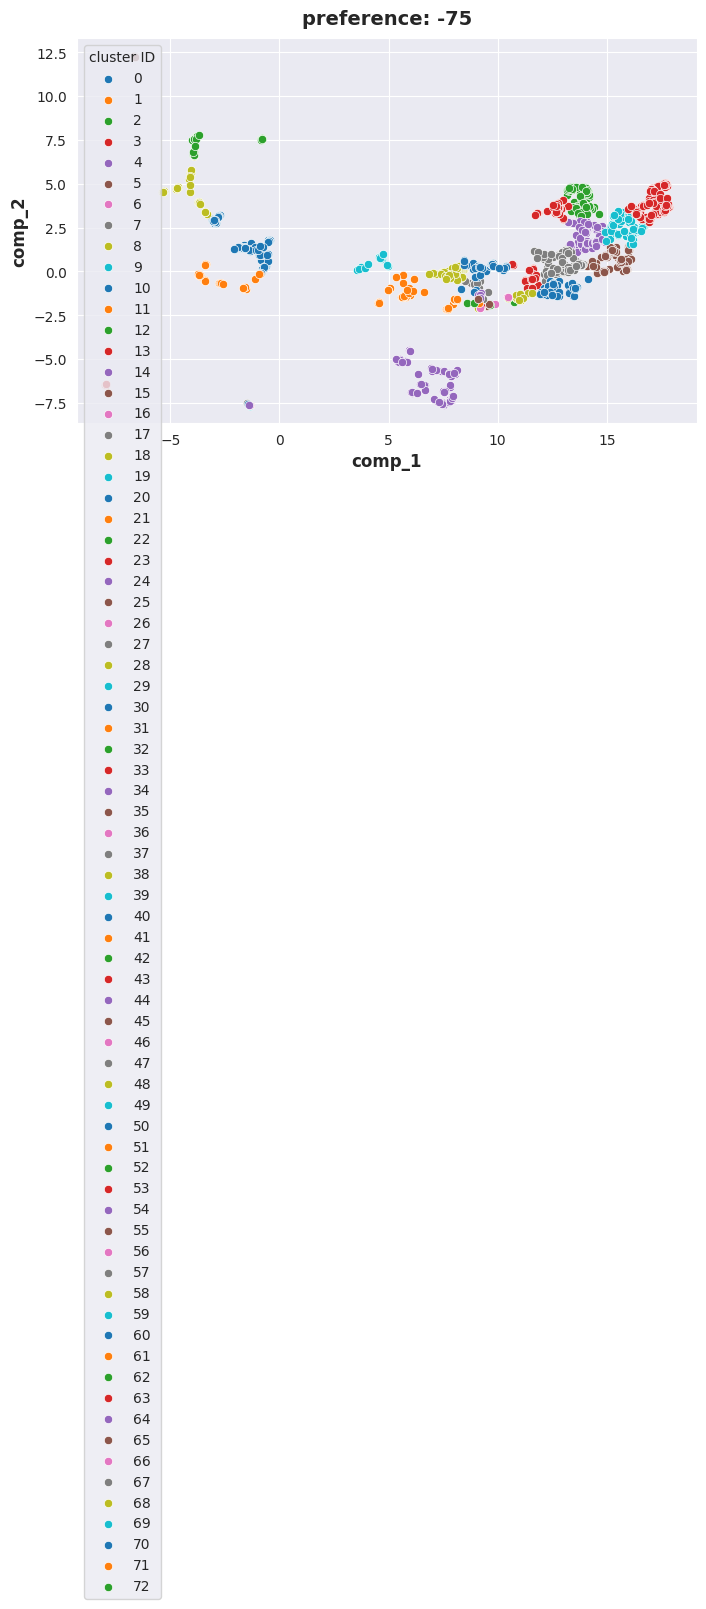

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


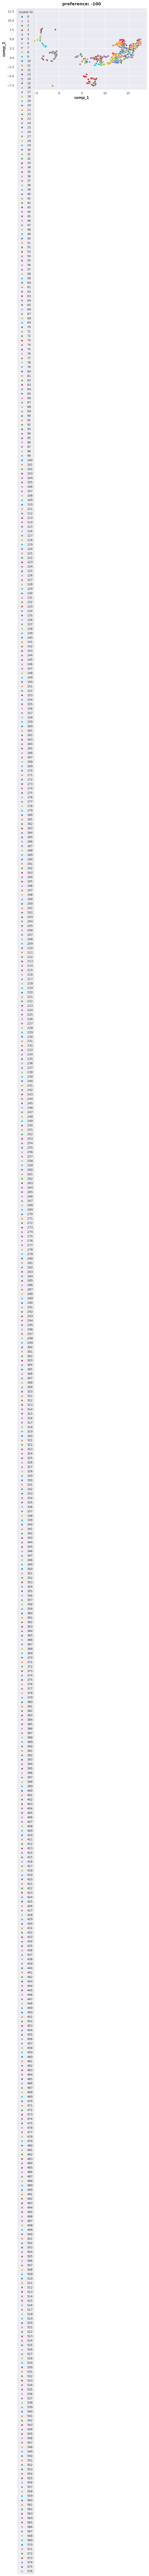


CPU times: user 5min 14s, sys: 4.33 s, total: 5min 19s
Wall time: 5min 19s


In [39]:
%%time

prefs = [-10, -25, -50, -75, -100]

for p in prefs:
    affprop = AffinityPropagation(preference=p, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=p, noise_exist=False)
    convergence_check(affprop)

==> In contrast to *damping*, *preference* seems to have a much stronger influcence on the number of formed clusters ***for this particular dataset***.

### Re-run with optimised *preference*

In [40]:
%%time

start_time = time.time()

affprop = AffinityPropagation(preference=-75, max_iter=500, random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

training_times.append(time.time() - start_time)


CPU times: user 15.3 s, sys: 174 ms, total: 15.5 s
Wall time: 15.6 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


## Algo 5: DBSCAN

DBSCAN is a density-based algorithm. It assumes that clusters are of a **roughly similar density**. Its main hyperparameter is ***eps***, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Its default value is 0.5. This algorithm comes with a second important hyperparamter, which is ***min_samples***. It represents the number of samples in a neighborhood for a point to be considered as a core point. *Min_samples* is not tuned in the context of this exercise though.

In contrast to algorithms 1 to 4, DBSCAN is **not iterative but deterministic** in nature. Thus no convergence check is required here.

A core feature of DBSCAN is that it also attempts to identify "**noise**", i.e. data points not associated with any cluster. Those data points are represented in the following plots as blue stars with cluster ID -1.

In [41]:
# hyperparamter to tune

dbscan_hparam = "eps"

### Vanilla run (defaults for all hyperparameters)

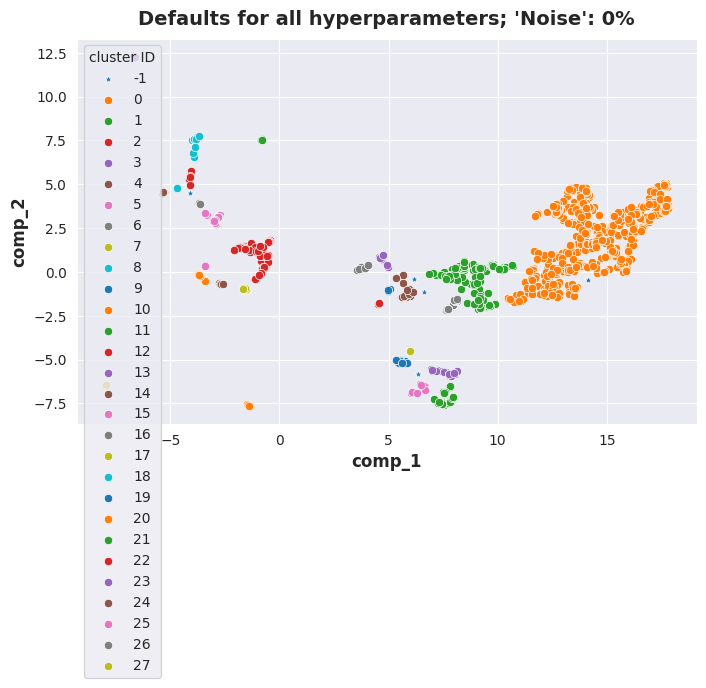

CPU times: user 2.51 s, sys: 142 ms, total: 2.65 s
Wall time: 2.52 s


In [42]:
%%time

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The result looks quite convincing! It is important to note here that the structure of data is not at odds with what DBSCAN requires in order to work satisfactorily, i.e. that the **clusters are of a roughly similar density**. Approximately 4% off all datapoints were identified as noise here.

### Tuning runs for *eps*

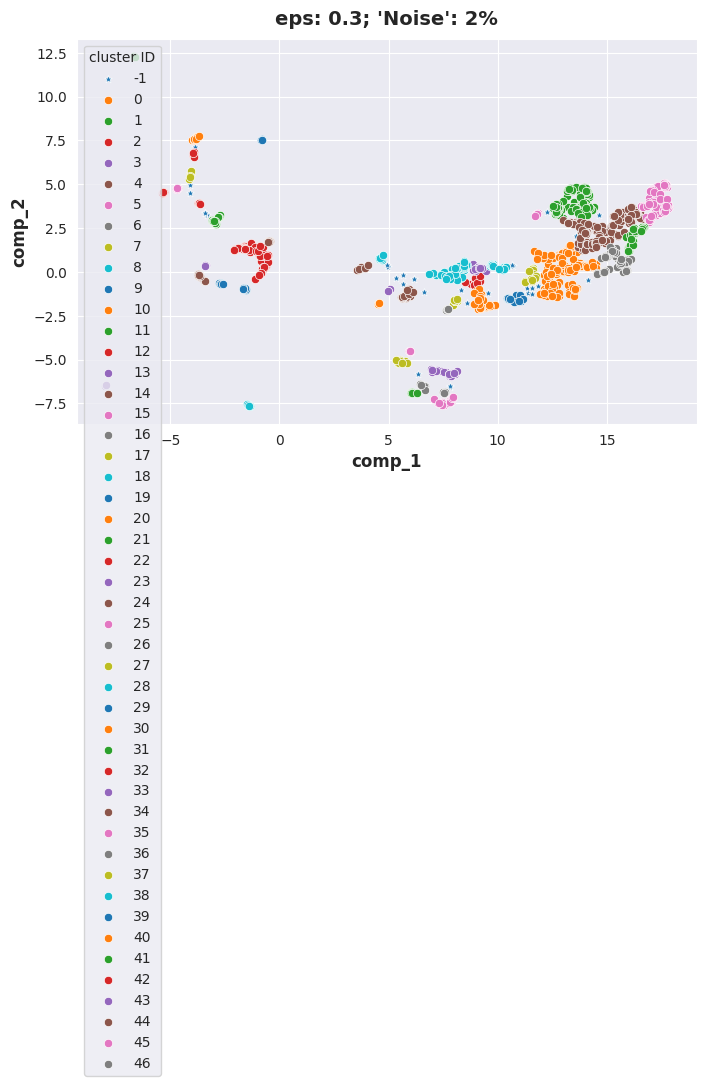

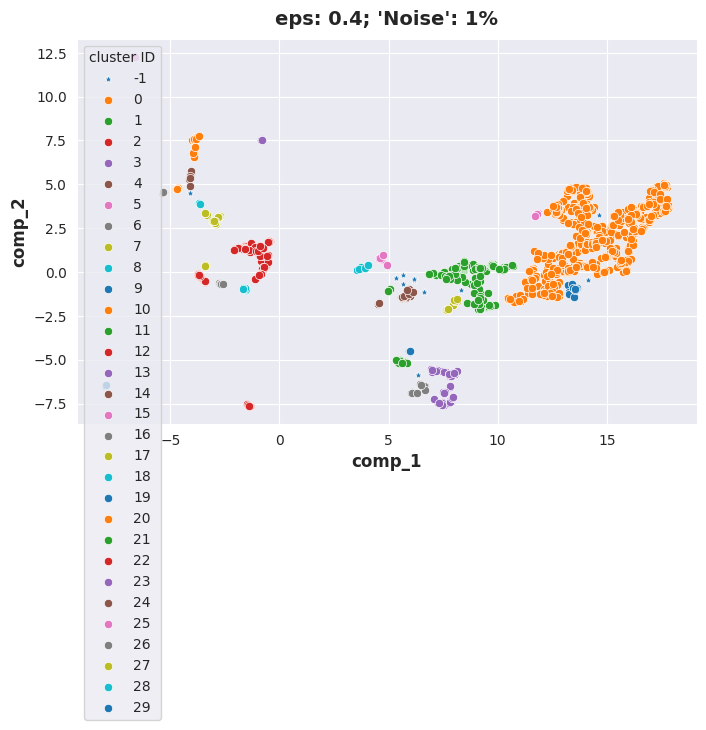

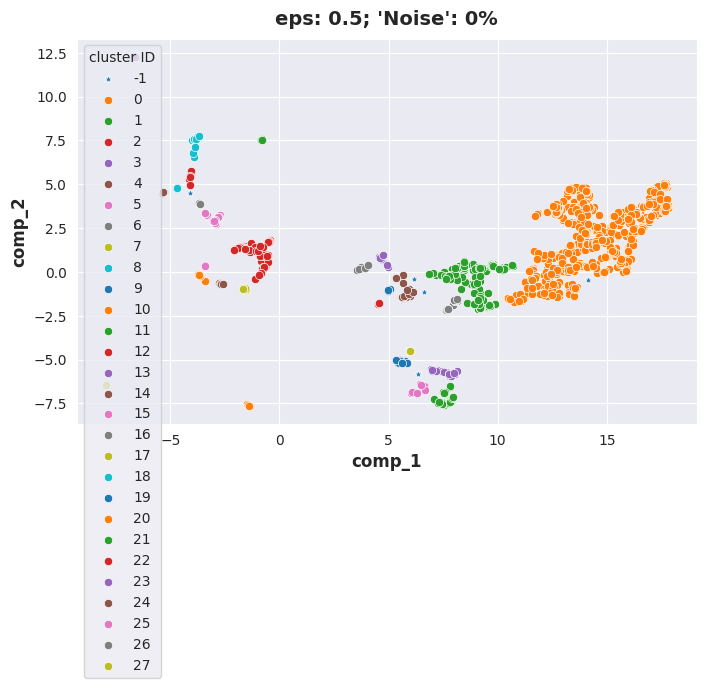

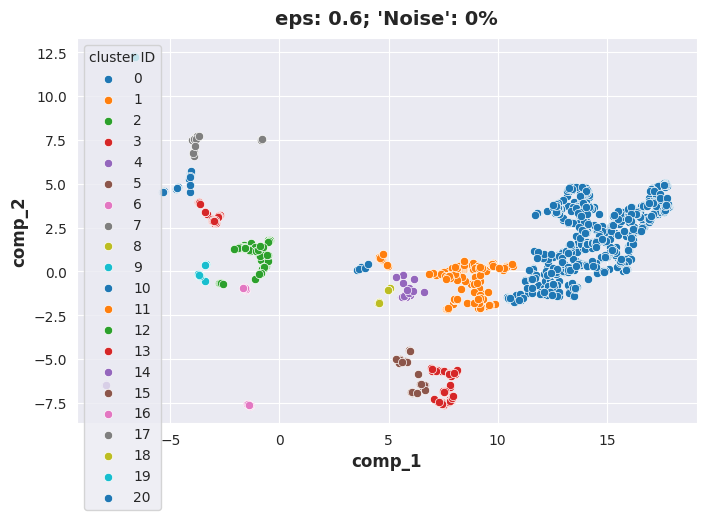

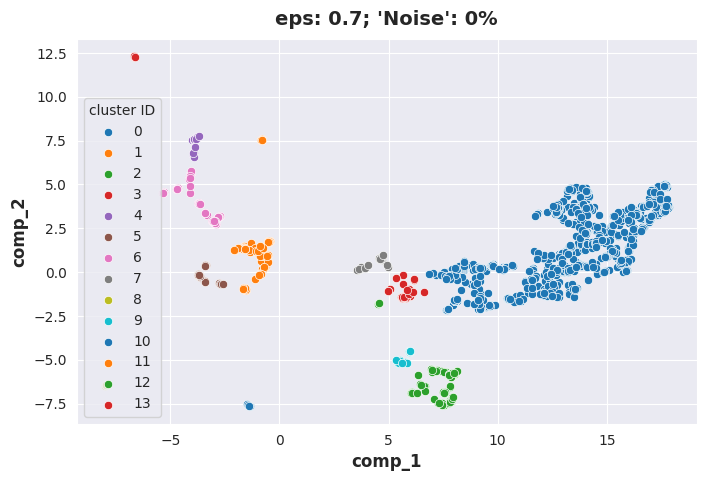

CPU times: user 10.6 s, sys: 624 ms, total: 11.2 s
Wall time: 10.8 s


In [43]:
%%time

for e in [0.3, 0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

==> The algorithm shows quite a high sensitivity to ***eps***. A value of around 0.6 seems to work best for this particular dataset.

### Re-run with optimised *eps*

In [44]:
%%time

eps_val = 0.6

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 16.8 ms, sys: 2.02 ms, total: 18.8 ms
Wall time: 23.5 ms


## Algo 6: OPTICS

OPTICS can be considered an "advanced" version of DBSCAN. Its key difference to the latter is that OPTICS features a **variable neighborhood radius**. Its main hyperparameter to tune is ***min_samples***, which is the number of samples in a neighborhood for a point to be considered as a core point.

In [45]:
# hyperparamter to tune

optics_hparam = "min_samples"

### Vanilla run (defaults for all hyperparameters)

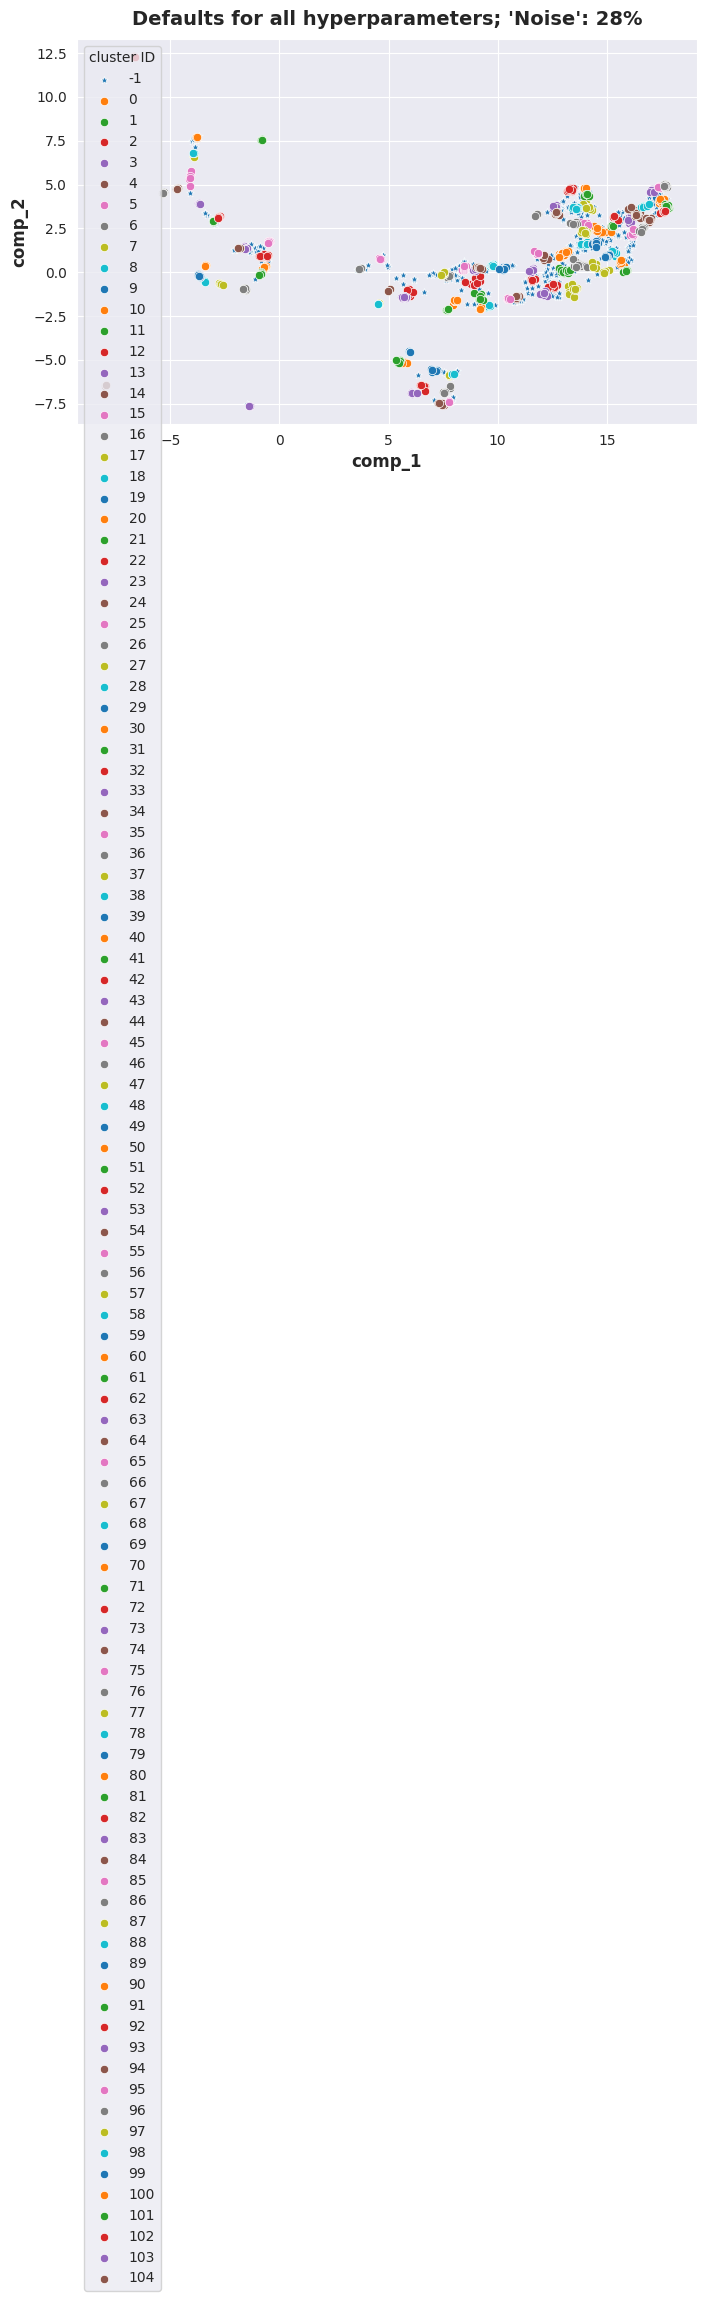

CPU times: user 15.1 s, sys: 1.4 s, total: 16.5 s
Wall time: 28.4 s


In [46]:
%%time

optics = OPTICS(n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The algorithm identified a considerable number of clusters. Furthermore, a substantial partion of the dataset is labelled as "noise".

### Tuning runs for *min_samples*

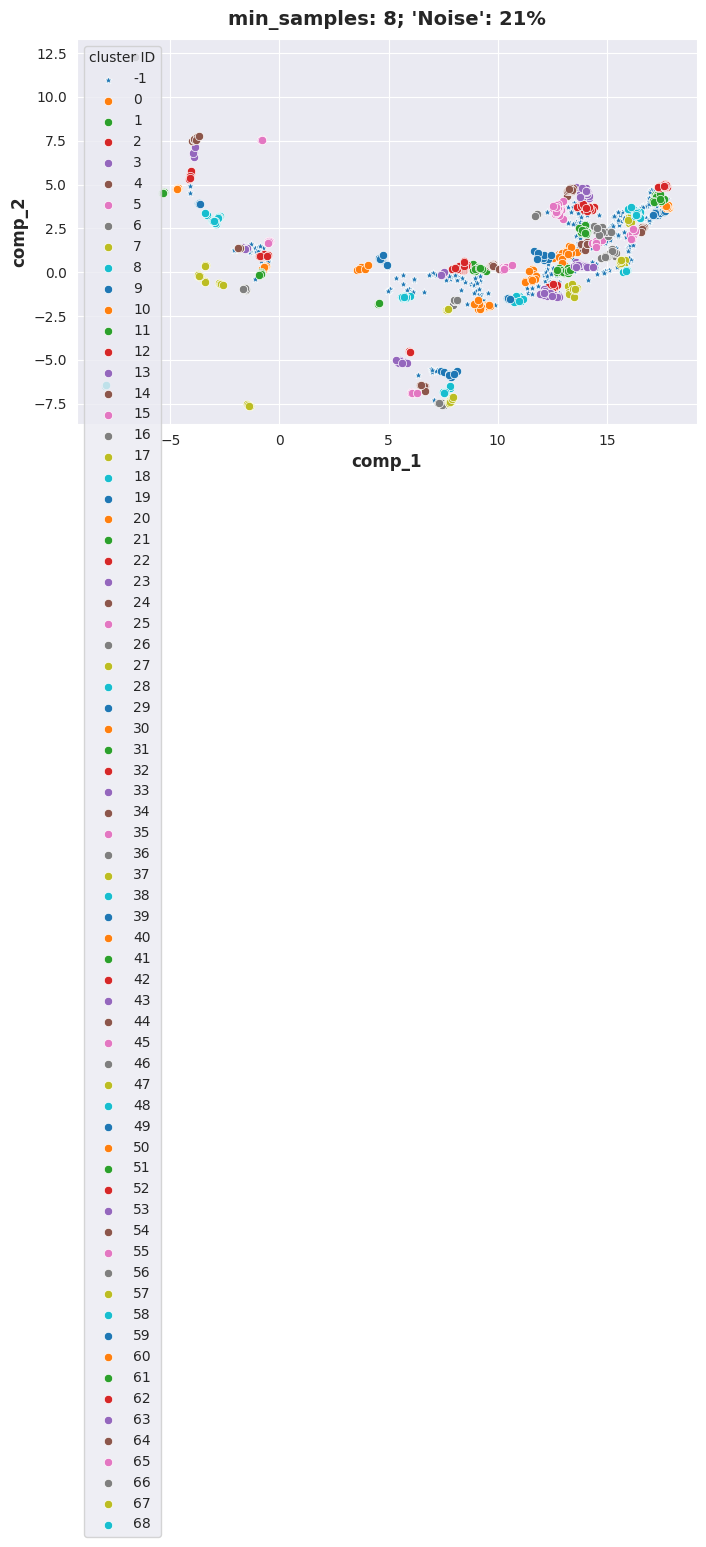

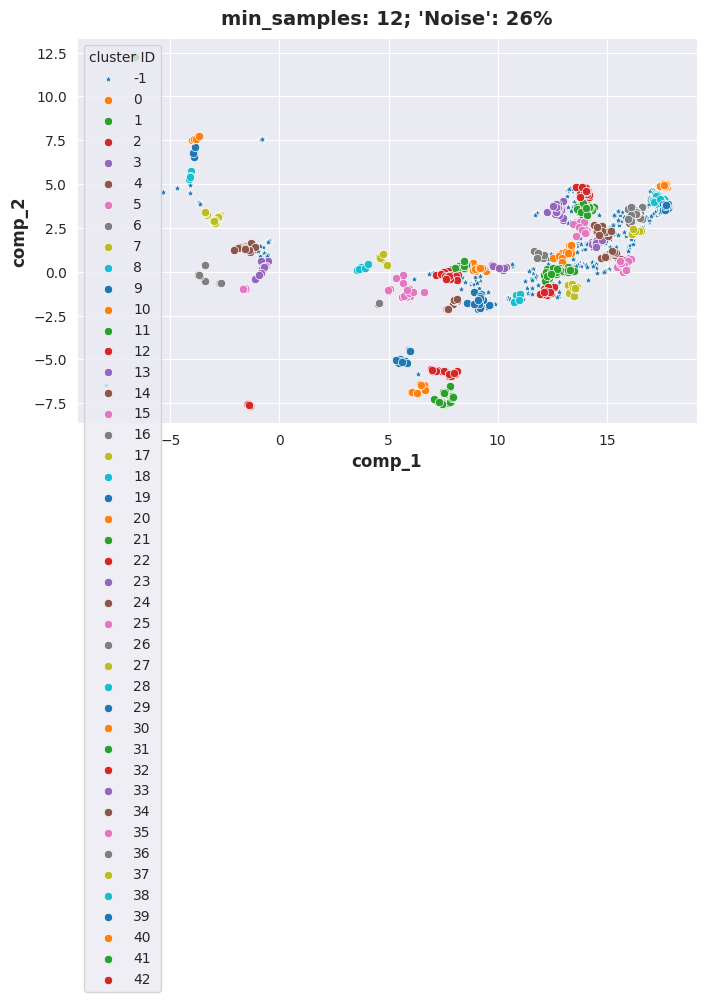

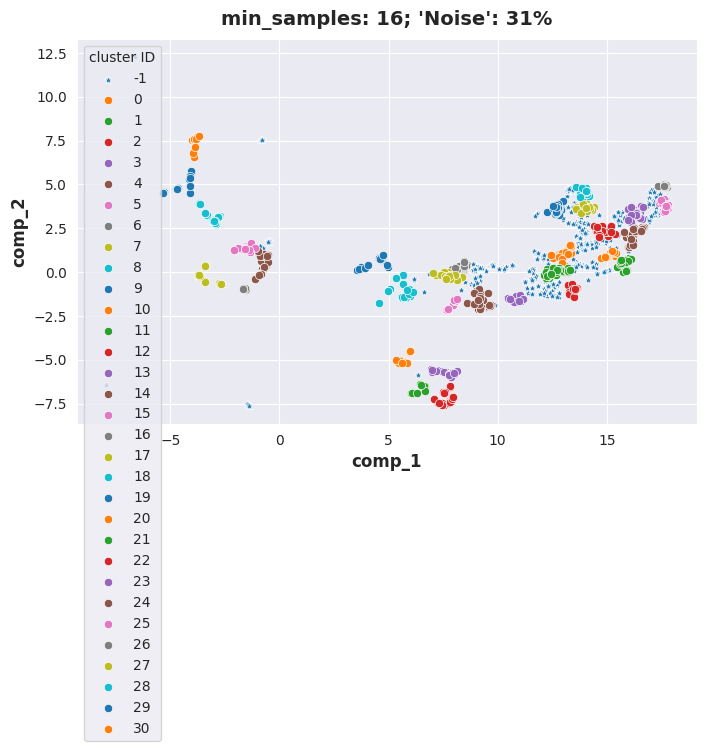

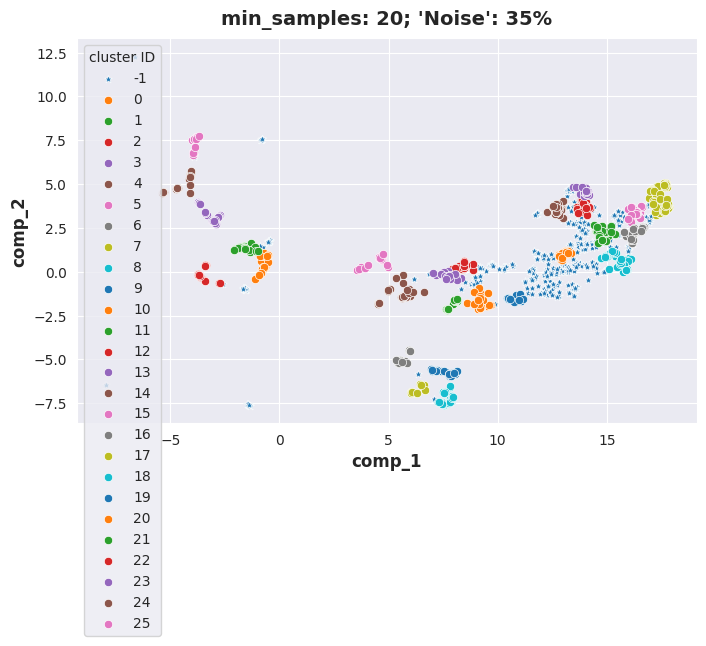

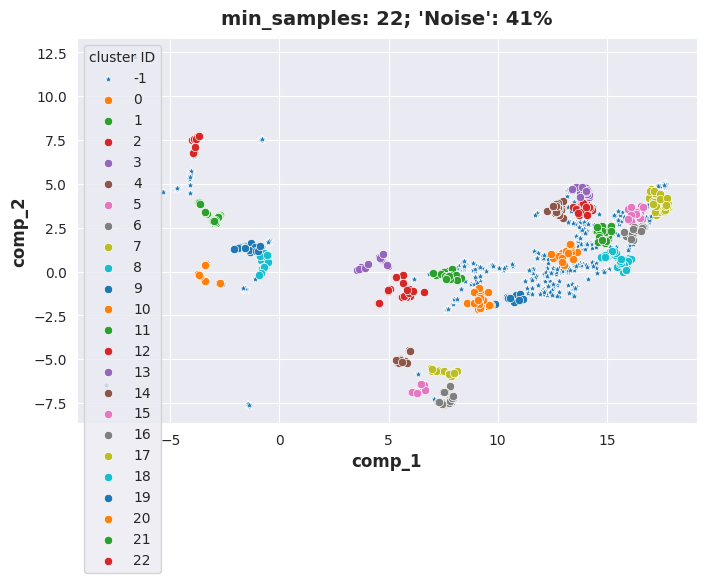

CPU times: user 38.7 s, sys: 6.67 s, total: 45.3 s
Wall time: 1min 44s


In [47]:
%%time

for n_samples in [8, 12, 16, 20, 22]:

    optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

    labels_6 = optics.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

==> An approprate value for *min_samples* would be around 20.

### Re-run with optimised *min_samples*

In [48]:
%%time

n_samples = 20

start_time = time.time()

optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 4.7 s, sys: 1.14 s, total: 5.84 s
Wall time: 18.2 s


# Comparison of training times

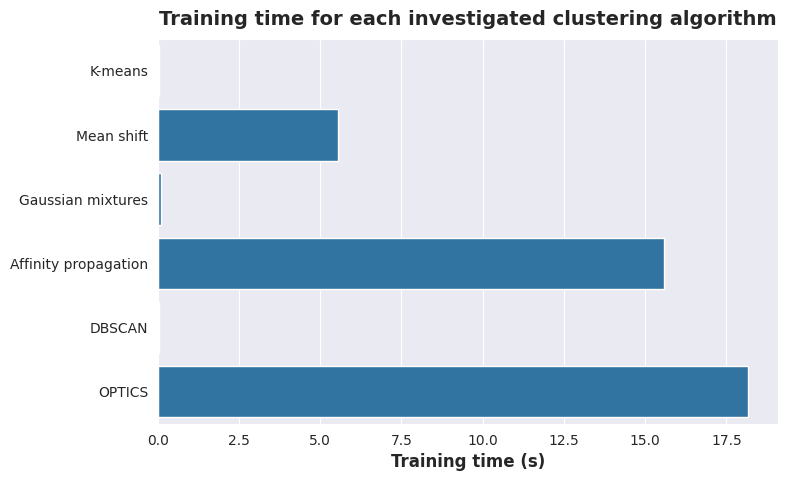

In [49]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

==> The training times across the investigated algorithms **vary considerably**! On the scale of the training times for the Mean shift and OPTICS algorithms, the training times of the other algos practically vanish. Interestingly enough though, when allowing for data points to be considered as "noise" for the Mean shift algo, its training time reduced substantially. For the following, its training time for *cluster_all=False* is taken as its relevant time. Furthermore, OPTICS is excluded so to allow for a comparison of the training times of the remaining algos on a more sensible scale.

In [50]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

In [51]:
algos = ['K-means','Gaussian mixtures', 'Affinity propagation', 'DBSCAN','OPTICS','Mean shift']

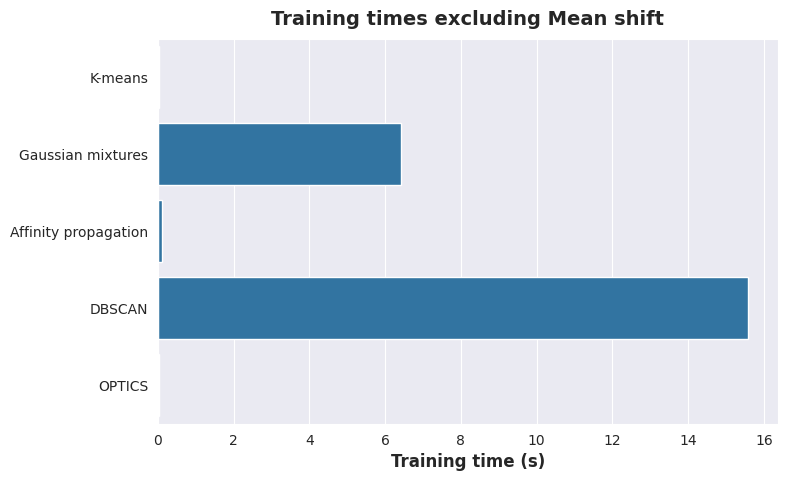

In [52]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos[:-1], x=training_times[:-1])
plt.title("Training times excluding Mean shift")
plt.xlabel("Training time (s)")
plt.show()

# Conclusions

As with practically everything else in the machine learning domain, when it comes to clustering there is no "one-size-fits-all" algorithm. Different algorithms tend to be better depending on the structure of the data and in particluar **to what extent this structure is in line with what each algorithm relies on in order to work satisfactorily**. For the relatively simple data structure of the "wine dataset", practically all investigated algorithms performed well (after more or less hyperparameter turning).

Two important caveats regarding the results of this "study":
- Only the **single "most important" hyperparameter** was considered for tuning for each algorithm.
- The **dataset** employed here is **very small**. For datasets of a more real-world size, the relative performance in terms of training times will most likely be different.